In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import os
from IPython.display import clear_output


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
!pwd
!ls
os.chdir("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis")


/content/drive/.shortcut-targets-by-id/10BsjhKdgzzKZGvv6gvrJPAE2TlliJlTG/MIMIC_Survival_Analysis
 abp_alarm.csv			       spO2_alarm.csv
 chartevents.ipynb		       static_patient_data_v2.csv
 chartevents_test_og.csv	       static_test_data.csv
 chartevents_train.csv		       static_test_data_diag.csv
 cumhaz_curves.feather		       static_test_icu_los.csv
 diag.csv			       static_test_predict.csv
'Diagnosis TimeToDeath EDA.ipynb'      static_test_predict_los.csv
 disease_group_stats.feather	       static_train_data.csv
 entire_mimic_iii_exported_tables      static_train_data_diag.csv
 hours_until_leave_icu.ipynb	       static_train_icu_los.csv
 hr_alarm.csv			       static_train_icu_los.gsheet
 hr_spo02_resp.csv		       static_train_predict.csv
 kaplan_cox_regression		       static_train_predict_los.csv
 mimic_data_test.feather	       static_train_test_model.ipynb
 mimic_data_train.feather	       static_val_data.csv
 mimic_patients_in_icu_test.feather    static_val_data_diag.csv
 mimic_p

# Create Train Set

In [ ]:
chartevents1 = pd.read_csv('sa02_nbp_wt.csv')
chartevents1

,subject_id,itemid,charttime,label,category,value,valuenum,valueuom
0,16076,5817,2180-07-31 12:00:00,NBP Alarm [Low],NaN,85.0,85.0,mmHg
1,16076,5817,2180-08-14 21:00:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg
2,16076,8551,2180-07-30 18:30:00,NBP Alarm [High],NaN,160.0,160.0,mmHg
3,16076,8551,2180-08-12 08:00:00,NBP Alarm [High],NaN,160.0,160.0,mmHg
4,16076,5817,2180-07-30 17:47:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg
...,...,...,...,...,...,...,...,...
6441013,32810,5813,2100-09-28 18:00:00,ABP Alarm [Low],NaN,85.0,85.0,mmHg
6441014,32810,5817,2100-09-22 08:00:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg
6441015,32810,8547,2100-09-24 22:00:00,ABP Alarm [High],NaN,160.0,160.0,mmHg
6441016,32810,5817,2100-09-27 07:00:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg


In [ ]:
chartevents1.label.unique()

array(['NBP Alarm [Low]', 'NBP Alarm [High]', 'ABP Alarm [High]',
       'ABP Alarm [Low]'], dtype=object)

In [ ]:
chartevents2 = pd.read_csv('hr_spo02_resp.csv')
chartevents2

,subject_id,itemid,charttime,label,category,value,valuenum,valueuom
0,27661,5815,2129-10-10 11:30:00,HR Alarm [Low],NaN,60.0,60.0,BPM
1,27661,5815,2129-09-21 08:00:00,HR Alarm [Low],NaN,60.0,60.0,BPM
2,27661,5815,2129-07-26 08:00:00,HR Alarm [Low],NaN,60.0,60.0,BPM
3,27661,5820,2129-06-14 08:00:00,SpO2 Alarm [Low],NaN,90.0,90.0,%
4,27661,8549,2129-10-02 02:00:00,HR Alarm [High],NaN,120.0,120.0,BPM
...,...,...,...,...,...,...,...,...
15100879,22780,8554,2128-04-01 04:00:00,SpO2 Alarm [High],NaN,100.0,100.0,%
15100880,22780,5820,2128-04-01 14:00:00,SpO2 Alarm [Low],NaN,93.0,93.0,%
15100881,22780,5819,2128-03-26 09:00:00,Resp Alarm [Low],NaN,8.0,8.0,BPM
15100882,22780,8554,2128-03-31 10:00:00,SpO2 Alarm [High],NaN,100.0,100.0,%


In [ ]:
chartevents2.label.unique()

array(['HR Alarm [Low]', 'SpO2 Alarm [Low]', 'HR Alarm [High]',
       'Resp Alarm [High]', 'Resp Alarm [Low]', 'SpO2 Alarm [High]'],
      dtype=object)

In [ ]:
chartevents_train = chartevents1.append(chartevents2)

In [ ]:
chartevents_train

,subject_id,itemid,charttime,label,category,value,valuenum,valueuom
0,16076,5817,2180-07-31 12:00:00,NBP Alarm [Low],NaN,85.0,85.0,mmHg
1,16076,5817,2180-08-14 21:00:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg
2,16076,8551,2180-07-30 18:30:00,NBP Alarm [High],NaN,160.0,160.0,mmHg
3,16076,8551,2180-08-12 08:00:00,NBP Alarm [High],NaN,160.0,160.0,mmHg
4,16076,5817,2180-07-30 17:47:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg
...,...,...,...,...,...,...,...,...
15100879,22780,8554,2128-04-01 04:00:00,SpO2 Alarm [High],NaN,100.0,100.0,%
15100880,22780,5820,2128-04-01 14:00:00,SpO2 Alarm [Low],NaN,93.0,93.0,%
15100881,22780,5819,2128-03-26 09:00:00,Resp Alarm [Low],NaN,8.0,8.0,BPM
15100882,22780,8554,2128-03-31 10:00:00,SpO2 Alarm [High],NaN,100.0,100.0,%


# Encode variables

In [ ]:
chartevents_encoded = pd.get_dummies(chartevents_train['label'])

In [ ]:
chartevents_encoded

,ABP Alarm [High],ABP Alarm [Low],HR Alarm [High],HR Alarm [Low],NBP Alarm [High],NBP Alarm [Low],Resp Alarm [High],Resp Alarm [Low],SpO2 Alarm [High],SpO2 Alarm [Low]
0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
15100879,0,0,0,0,0,0,0,0,1,0
15100880,0,0,0,0,0,0,0,0,0,1
15100881,0,0,0,0,0,0,0,1,0,0
15100882,0,0,0,0,0,0,0,0,1,0


In [ ]:
chartevents_encoded['BP Alarm [High]'] = 0
chartevents_encoded['BP Alarm [Low]'] = 0

chartevents_encoded['ABP Alarm [High]'] = chartevents_encoded['ABP Alarm [High]'].astype(int)
chartevents_encoded['ABP Alarm [Low]'] = chartevents_encoded['ABP Alarm [Low]'].astype(int)

In [ ]:
chartevents_encoded['ABP Alarm [High]'].unique()

array([0, 1])

In [ ]:
chartevents_encoded['ABP Alarm [High]'].dtype

dtype('int64')

In [ ]:
chartevents_encoded["BP Alarm [High]"] = chartevents_encoded[["ABP Alarm [High]", "NBP Alarm [High]"]].max(axis=1)

In [ ]:
chartevents_encoded["BP Alarm [Low]"] = chartevents_encoded[["ABP Alarm [Low]", "NBP Alarm [Low]"]].max(axis=1)

In [ ]:
check = chartevents_encoded['ABP Alarm [Low]']==1

In [ ]:
chartevents_encoded[check]

,ABP Alarm [High],ABP Alarm [Low],HR Alarm [High],HR Alarm [Low],NBP Alarm [High],NBP Alarm [Low],Resp Alarm [High],Resp Alarm [Low],SpO2 Alarm [High],SpO2 Alarm [Low],BP Alarm [High],BP Alarm [Low]
4792,0,1,0,0,0,0,0,0,0,0,0,1
4794,0,1,0,0,0,0,0,0,0,0,0,1
4800,0,1,0,0,0,0,0,0,0,0,0,1
4803,0,1,0,0,0,0,0,0,0,0,0,1
4806,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6440983,0,1,0,0,0,0,0,0,0,0,0,1
6440996,0,1,0,0,0,0,0,0,0,0,0,1
6441003,0,1,0,0,0,0,0,0,0,0,0,1
6441004,0,1,0,0,0,0,0,0,0,0,0,1


In [ ]:
chartevents_encoded = chartevents_encoded.drop(['NBP Alarm [High]', 'NBP Alarm [Low]', 'ABP Alarm [Low]', 'NBP Alarm [Low]'], axis=1)

In [ ]:
chartevents_encoded

,ABP Alarm [High],HR Alarm [High],HR Alarm [Low],Resp Alarm [High],Resp Alarm [Low],SpO2 Alarm [High],SpO2 Alarm [Low],BP Alarm [High],BP Alarm [Low]
0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
15100879,0,0,0,0,0,1,0,0,0
15100880,0,0,0,0,0,0,1,0,0
15100881,0,0,0,0,1,0,0,0,0
15100882,0,0,0,0,0,1,0,0,0


In [ ]:
chartevents_train = pd.concat([chartevents_train, chartevents_encoded], axis = 1)

In [ ]:
chartevents_train

,subject_id,itemid,charttime,label,category,value,valuenum,valueuom,ABP Alarm [High],HR Alarm [High],HR Alarm [Low],Resp Alarm [High],Resp Alarm [Low],SpO2 Alarm [High],SpO2 Alarm [Low],BP Alarm [High],BP Alarm [Low]
0,16076,5817,2180-07-31 12:00:00,NBP Alarm [Low],NaN,85.0,85.0,mmHg,0,0,0,0,0,0,0,0,1
1,16076,5817,2180-08-14 21:00:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg,0,0,0,0,0,0,0,0,1
2,16076,8551,2180-07-30 18:30:00,NBP Alarm [High],NaN,160.0,160.0,mmHg,0,0,0,0,0,0,0,1,0
3,16076,8551,2180-08-12 08:00:00,NBP Alarm [High],NaN,160.0,160.0,mmHg,0,0,0,0,0,0,0,1,0
4,16076,5817,2180-07-30 17:47:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15100879,22780,8554,2128-04-01 04:00:00,SpO2 Alarm [High],NaN,100.0,100.0,%,0,0,0,0,0,1,0,0,0
15100880,22780,5820,2128-04-01 14:00:00,SpO2 Alarm [Low],NaN,93.0,93.0,%,0,0,0,0,0,0,1,0,0
15100881,22780,5819,2128-03-26 09:00:00,Resp Alarm [Low],NaN,8.0,8.0,BPM,0,0,0,0,1,0,0,0,0
15100882,22780,8554,2128-03-31 10:00:00,SpO2 Alarm [High],NaN,100.0,100.0,%,0,0,0,0,0,1,0,0,0


In [ ]:
chartevents_train.to_csv("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis/chartevents_train.csv")

# Create Test Set


In [ ]:
chartevents_test = pd.read_csv('chartevents_test_og.csv')

In [ ]:
chartevents_test_encoded = pd.get_dummies(chartevents_test['label'])

In [ ]:
chartevents_test_encoded

,ABP Alarm [High],ABP Alarm [Low],HR Alarm [High],HR Alarm [Low],NBP Alarm [High],NBP Alarm [Low],Resp Alarm [High],Resp Alarm [Low],SpO2 Alarm [High],SpO2 Alarm [Low]
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7852615,1,0,0,0,0,0,0,0,0,0
7852616,0,0,0,0,0,0,0,0,1,0
7852617,0,0,0,0,0,0,0,1,0,0
7852618,0,0,0,0,0,0,0,0,1,0


In [ ]:
chartevents_test_encoded["BP Alarm [High]"] = chartevents_test_encoded[["ABP Alarm [High]", "NBP Alarm [High]"]].max(axis=1)
chartevents_test_encoded["BP Alarm [Low]"] = chartevents_test_encoded[["ABP Alarm [Low]", "NBP Alarm [Low]"]].max(axis=1)

In [ ]:
chartevents_test_encoded

,ABP Alarm [High],ABP Alarm [Low],HR Alarm [High],HR Alarm [Low],NBP Alarm [High],NBP Alarm [Low],Resp Alarm [High],Resp Alarm [Low],SpO2 Alarm [High],SpO2 Alarm [Low],BP Alarm [High],BP Alarm [Low]
0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7852615,1,0,0,0,0,0,0,0,0,0,1,0
7852616,0,0,0,0,0,0,0,0,1,0,0,0
7852617,0,0,0,0,0,0,0,1,0,0,0,0
7852618,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
chartevents_test = pd.concat([chartevents_test, chartevents_test_encoded], axis = 1)

In [ ]:
chartevents_test

,subject_id,itemid,charttime,label,category,value,valuenum,valueuom,ABP Alarm [High],ABP Alarm [Low],HR Alarm [High],HR Alarm [Low],NBP Alarm [High],NBP Alarm [Low],Resp Alarm [High],Resp Alarm [Low],SpO2 Alarm [High],SpO2 Alarm [Low],BP Alarm [High],BP Alarm [Low]
0,9518,8553,2119-03-30 08:00:00,Resp Alarm [High],NaN,35.0,35.0,BPM,0,0,0,0,0,0,1,0,0,0,0,0
1,9518,5819,2119-04-02 14:00:00,Resp Alarm [Low],NaN,8.0,8.0,BPM,0,0,0,0,0,0,0,1,0,0,0,0
2,9518,5820,2120-08-23 16:00:00,SpO2 Alarm [Low],NaN,88.0,88.0,%,0,0,0,0,0,0,0,0,0,1,0,0
3,9518,8553,2119-03-29 04:00:00,Resp Alarm [High],NaN,35.0,35.0,BPM,0,0,0,0,0,0,1,0,0,0,0,0
4,9518,5815,2119-03-30 10:00:00,HR Alarm [Low],NaN,60.0,60.0,BPM,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7852615,9479,8547,2175-02-10 12:00:00,ABP Alarm [High],NaN,160.0,160.0,mmHg,1,0,0,0,0,0,0,0,0,0,1,0
7852616,9479,8554,2175-02-10 12:00:00,SpO2 Alarm [High],NaN,100.0,100.0,%,0,0,0,0,0,0,0,0,1,0,0,0
7852617,9479,5819,2175-02-11 04:00:00,Resp Alarm [Low],NaN,8.0,8.0,BPM,0,0,0,0,0,0,0,1,0,0,0,0
7852618,9479,8554,2175-02-10 20:00:00,SpO2 Alarm [High],NaN,100.0,100.0,%,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
chartevents_test.to_csv("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis/chartevents_test.csv")

# Split datasets for eda

In [ ]:
hr_alarm = chartevents[['subject_id', 'itemid', 'charttime', 'label', 'category','value', 'valuenum', 'valueuom', 'HR Alarm [High]', 'HR Alarm [Low]']]
hr = ['HR Alarm [High]', 'HR Alarm [Low]']
hr_alarm = hr_alarm[hr_alarm.label.isin(hr)]

abp_alarm = chartevents[['subject_id', 'itemid', 'charttime', 'label', 'category','value', 'valuenum', 'valueuom', 'ABP Alarm [High]', 'ABP Alarm [Low]']]
abp = ['ABP Alarm [High]', 'ABP Alarm [Low]']
abp_alarm = abp_alarm[abp_alarm.label.isin(abp)]

nbp_alarm = chartevents[['subject_id', 'itemid', 'charttime', 'label', 'category','value', 'valuenum', 'valueuom', 'ABP Alarm [High]', 'NBP Alarm [Low]']]
nbp = ['NBP Alarm [High]', 'NBP Alarm [Low]']
nbp_alarm = nbp_alarm[nbp_alarm.label.isin(nbp)]

resp_alarm = chartevents[['subject_id', 'itemid', 'charttime', 'label', 'category','value', 'valuenum', 'valueuom', 'Resp Alarm [High]', 'Resp Alarm [Low]']]
resp = ['Resp Alarm [High]', 'Resp Alarm [Low]']
resp_alarm = resp_alarm[resp_alarm.label.isin(resp)]

spO2_alarm = chartevents[['subject_id', 'itemid', 'charttime', 'label', 'category','value', 'valuenum', 'valueuom', 'SpO2 Alarm [High]', 'SpO2 Alarm [Low]']]
spO2 = ['SpO2 Alarm [High]', 'SpO2 Alarm [Low]']
spO2_alarm = spO2_alarm[spO2_alarm.label.isin(spO2)]

In [ ]:
hr_alarm.to_csv("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis/hr_alarm.csv", index = False)
abp_alarm.to_csv("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis/abp_alarm.csv", index = False)
nbp_alarm.to_csv("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis/nbp_alarm.csv", index = False)
resp_alarm.to_csv("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis/resp_alarm.csv", index = False)
spO2_alarm.to_csv("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis/spO2_alarm.csv", index = False)

# EDA

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
!pwd
!ls
os.chdir("/content/drive/My Drive/DS5500 Applications in Data Science/Project/MIMIC_Survival_Analysis")

/content
drive  sample_data


In [ ]:
# hr_alarm = pd.read_csv('hr_alarm.csv')
# abp_alarm = pd.read_csv('abp_alarm.csv')
# nbp_alarm = pd.read_csv('nbp_alarm.csv')
# resp_alarm = pd.read_csv('resp_alarm.csv')
spO2_alarm = pd.read_csv('spO2_alarm.csv')

In [ ]:
static_train_data = pd.read_csv('static_train_data.csv')
static_val_data = pd.read_csv('static_val_data.csv')
static_test_data = pd.read_csv('static_test_data.csv')

In [ ]:
# hr_alarm['valuenum'] = hr_alarm['valuenum'].replace(np.nan, 0)
# abp_alarm['valuenum'] = abp_alarm['valuenum'].replace(np.nan, 0)
# nbp_alarm['valuenum'] = nbp_alarm['valuenum'].replace(np.nan, 0)
# resp_alarm['valuenum'] = resp_alarm['valuenum'].replace(np.nan, 0)
spO2_alarm['valuenum'] = spO2_alarm['valuenum'].replace(np.nan, 0)

In [ ]:
# hr_alarm_train = hr_alarm.merge(static_train_data, how = 'inner')
# abp_alarm_train = abp_alarm.merge(static_train_data, how = 'inner')
# nbp_alarm_train = nbp_alarm.merge(static_train_data, how = 'inner')
# resp_alarm_train = resp_alarm.merge(static_train_data, how = 'inner')
spO2_alarm_train = spO2_alarm.merge(static_train_data, how = 'inner')

# Heart Rate

In [ ]:
hr_alarm_train

,subject_id,itemid,charttime,label,category,value,valuenum,valueuom,HR Alarm [High],HR Alarm [Low],Unnamed: 0,hadm_id,icustay_id,anytime_expire_flag,hospital_expire_flag,icu_expire_flag,time_of_death,time_until_death,hours_until_death,days_until_death,admittime,dischtime,intime,outtime,time_until_hospital_exit,days_until_hospital_exit,admission_time_until_icu,hours_until_icu_admission,time_until_leave_ICU,hours_until_leave_ICU,icu_admit_age,female,dbsource,first_careunit,admission_type,marital_status,insurance,icd_blood,icd_circulatory,icd_congenital,icd_digestive,icd_endocrine,icd_genitourinary,icd_infectious,icd_injury,icd_mental,icd_misc,icd_muscular,icd_neoplasms,icd_nervous,icd_pregnancy,icd_prenatal,icd_respiratory,icd_skin,diagnosis,cardio,infection,brain,mental,gastro,trauma,respiratory,organ,blood,acute,failure,cancer,back,bone,pain,other,totalcats
0,27661,5815,2129-10-10 11:30:00,HR Alarm [Low],NaN,60.0,60.0,BPM,0,1,16832,105721,279028,1,0,0,2130-06-13 00:00:00,368 days 03:59:03,8835.0,368.0,2129-06-09 20:00:00,2129-06-15 16:20:00,2129-06-09 20:00:57,2129-06-15 16:45:34,5 days 20:19:03,5.0,0 days 00:00:57,0.0,5 days 20:44:37,140.0,79,0,carevue,MICU,EMERGENCY,MARRIED,Private,0.0,2.0,0.0,0.0,4.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,ALTERED MENTAL STATUS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,27661,5815,2129-09-21 08:00:00,HR Alarm [Low],NaN,60.0,60.0,BPM,0,1,16832,105721,279028,1,0,0,2130-06-13 00:00:00,368 days 03:59:03,8835.0,368.0,2129-06-09 20:00:00,2129-06-15 16:20:00,2129-06-09 20:00:57,2129-06-15 16:45:34,5 days 20:19:03,5.0,0 days 00:00:57,0.0,5 days 20:44:37,140.0,79,0,carevue,MICU,EMERGENCY,MARRIED,Private,0.0,2.0,0.0,0.0,4.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,ALTERED MENTAL STATUS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,27661,5815,2129-07-26 08:00:00,HR Alarm [Low],NaN,60.0,60.0,BPM,0,1,16832,105721,279028,1,0,0,2130-06-13 00:00:00,368 days 03:59:03,8835.0,368.0,2129-06-09 20:00:00,2129-06-15 16:20:00,2129-06-09 20:00:57,2129-06-15 16:45:34,5 days 20:19:03,5.0,0 days 00:00:57,0.0,5 days 20:44:37,140.0,79,0,carevue,MICU,EMERGENCY,MARRIED,Private,0.0,2.0,0.0,0.0,4.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,ALTERED MENTAL STATUS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,27661,8549,2129-10-02 02:00:00,HR Alarm [High],NaN,120.0,120.0,BPM,1,0,16832,105721,279028,1,0,0,2130-06-13 00:00:00,368 days 03:59:03,8835.0,368.0,2129-06-09 20:00:00,2129-06-15 16:20:00,2129-06-09 20:00:57,2129-06-15 16:45:34,5 days 20:19:03,5.0,0 days 00:00:57,0.0,5 days 20:44:37,140.0,79,0,carevue,MICU,EMERGENCY,MARRIED,Private,0.0,2.0,0.0,0.0,4.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,ALTERED MENTAL STATUS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,27661,8549,2129-10-02 09:00:00,HR Alarm [High],NaN,120.0,120.0,BPM,1,0,16832,105721,279028,1,0,0,2130-06-13 00:00:00,368 days 03:59:03,8835.0,368.0,2129-06-09 20:00:00,2129-06-15 16:20:00,2129-06-09 20:00:57,2129-06-15 16:45:34,5 days 20:19:03,5.0,0 days 00:00:57,0.0,5 days 20:44:37,140.0,79,0,carevue,MICU,EMERGENCY,MARRIED,Private,0.0,2.0,0.0,0.0,4.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,ALTERED MENTAL STATUS,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072767,22780,5815,2128-03-29 00:00:00,HR Alarm [Low],NaN,50.0,50.0,BPM,0,1,19583,138174,231212,1,0,0,2129-10-24 00:00:00,581 days 02:11:41,13946.0,581.0,2128-03-19 21:25:00,2128-04-09 16:00:00,2128-03-21 21:48:19,2128-04-03 15:17:44,18 days 18:11:41,18.0,2 days 00:23:19,48.0,12 days 17:29:25,305.0,78,0,carevue,SICU,EMERGENCY,SINGLE,Medicare,1.0,8.0,0.0,1.0,1.0,1.0,0.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,RT LEG ARTERIAL OCCLUSION,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5072768,22780,5815,2128-03-24 00:00:00,HR Alarm [Low],NaN,50.0,50.0,BPM,0,1

In [ ]:
hr_alarm_train.value.describe()

count    5.064750e+06
mean     8.878080e+01
std      3.537502e+01
min      0.000000e+00
25%      5.500000e+01
50%      9.000000e+01
75%      1.200000e+02
max      4.560000e+02
Name: value, dtype: float64

In [ ]:
hr_alarm_train.value.median()

90.0

In [ ]:
hr_alarm_train.value.nunique()

115

In [ ]:
hr_alarm_train_hi_expire = hr_alarm_train[(hr_alarm_train['HR Alarm [High]'] == 1) & (hr_alarm_train['hospital_expire_flag'] == 1)]
hr_alarm_train_hi_noexpire = hr_alarm_train[(hr_alarm_train['HR Alarm [High]'] == 1) & (hr_alarm_train['hospital_expire_flag'] == 0)]
hr_alarm_train_lo_expire = hr_alarm_train[(hr_alarm_train['HR Alarm [Low]'] == 1) & (hr_alarm_train['hospital_expire_flag'] == 1)]
hr_alarm_train_lo_noexpire = hr_alarm_train[(hr_alarm_train['HR Alarm [Low]'] == 1) & (hr_alarm_train['hospital_expire_flag'] == 0)]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


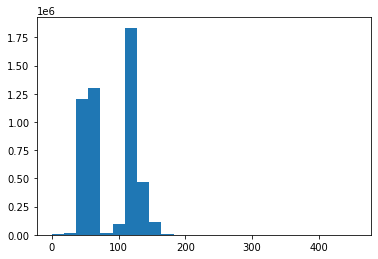

In [ ]:
hr_hist_value= plt.hist(hr_alarm_train['value'], bins =25)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


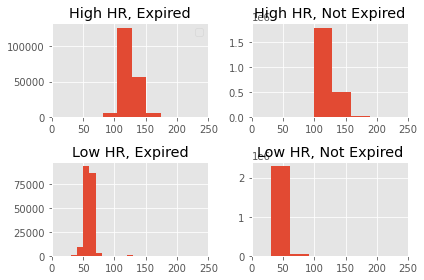

In [ ]:
plt.style.use('ggplot')
plt.close('all')

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(hr_alarm_train_hi_expire['value'], 15, histtype='bar')
ax0.legend(prop={'size': 10})
ax0.set_title('High HR, Expired')
ax0.set_xlim([0, 250])

ax1.hist(hr_alarm_train_hi_noexpire['value'], 15, histtype='bar')
ax1.set_title('High HR, Not Expired')
ax1.set_xlim([0, 250])

ax2.hist(hr_alarm_train_lo_expire['value'], 15, histtype='bar')
ax2.set_title('Low HR, Expired')
ax2.set_xlim([0, 250])

ax3.hist(hr_alarm_train_lo_noexpire['value'], 15, histtype='bar')
ax3.set_title('Low HR, Not Expired')
ax3.set_xlim([0, 250])

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


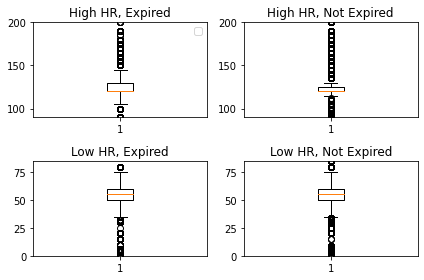

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.boxplot(hr_alarm_train_hi_expire['valuenum'])
ax0.legend(prop={'size': 10})
ax0.set_title('High HR, Expired')
ax0.set_ylim([90, 200])

ax1.boxplot(hr_alarm_train_hi_noexpire['valuenum'])
ax1.set_title('High HR, Not Expired')
ax1.set_ylim([90, 200])

ax2.boxplot(hr_alarm_train_lo_expire['valuenum'])
ax2.set_title('Low HR, Expired')
ax2.set_ylim([0, 85])

ax3.boxplot(hr_alarm_train_lo_noexpire['valuenum'])
ax3.set_title('Low HR, Not Expired')
ax3.set_ylim([0, 85])

fig.tight_layout()
plt.show()

# ABP

In [ ]:
abp_alarm.value.describe()

count    2.425243e+06
mean     1.159221e+02
std      4.047535e+01
min      0.000000e+00
25%      9.000000e+01
50%      1.000000e+02
75%      1.600000e+02
max      3.000000e+02
Name: value, dtype: float64

In [ ]:
abp_alarm.value.nunique()

81

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


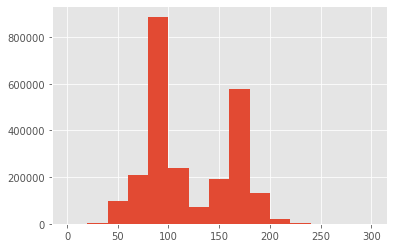

In [ ]:
abp_hist_value= plt.hist(abp_alarm_train['value'], bins =15)

In [ ]:
abp_alarm_train_hi_expire = abp_alarm_train[(abp_alarm_train['ABP Alarm [High]'] == 1) & (abp_alarm_train['hospital_expire_flag'] == 1)]
abp_alarm_train_hi_noexpire = abp_alarm_train[(abp_alarm_train['ABP Alarm [High]'] == 1) & (abp_alarm_train['hospital_expire_flag'] == 0)]
abp_alarm_train_lo_expire = abp_alarm_train[(abp_alarm_train['ABP Alarm [Low]'] == 1) & (abp_alarm_train['hospital_expire_flag'] == 1)]
abp_alarm_train_lo_noexpire = abp_alarm_train[(abp_alarm_train['ABP Alarm [Low]'] == 1) & (abp_alarm_train['hospital_expire_flag'] == 0)]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


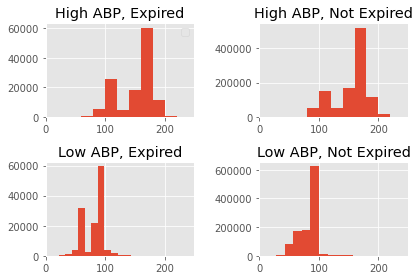

In [ ]:
plt.style.use('ggplot')
plt.close('all')

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(abp_alarm_train_hi_expire['value'], 15, histtype='bar')
ax0.legend(prop={'size': 10})
ax0.set_title('High ABP, Expired')
ax0.set_xlim([0, 250])

ax1.hist(abp_alarm_train_hi_noexpire['value'], 15, histtype='bar')
ax1.set_title('High ABP, Not Expired')
ax1.set_xlim([0, 250])

ax2.hist(abp_alarm_train_lo_expire['value'], 15, histtype='bar')
ax2.set_title('Low ABP, Expired')
ax2.set_xlim([0, 250])

ax3.hist(abp_alarm_train_lo_noexpire['value'], 15, histtype='bar')
ax3.set_title('Low ABP, Not Expired')
ax3.set_xlim([0, 250])

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


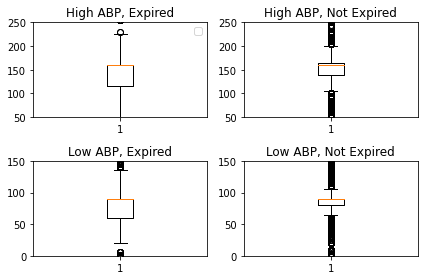

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.boxplot(abp_alarm_train_hi_expire['valuenum'])
ax0.legend(prop={'size': 10})
ax0.set_title('High ABP, Expired')
ax0.set_ylim([50, 250])

ax1.boxplot(abp_alarm_train_hi_noexpire['valuenum'])
ax1.set_title('High ABP, Not Expired')
ax1.set_ylim([50, 250])

ax2.boxplot(abp_alarm_train_lo_expire['valuenum'])
ax2.set_title('Low ABP, Expired')
ax2.set_ylim([0, 150])

ax3.boxplot(abp_alarm_train_lo_noexpire['valuenum'])
ax3.set_title('Low ABP, Not Expired')
ax3.set_ylim([0, 150])

fig.tight_layout()
plt.show()

# NBP

In [ ]:
nbp_alarm.head()

,subject_id,itemid,charttime,label,category,value,valuenum,valueuom,NBP Alarm [High],NBP Alarm [Low]
0,16076,5817,2180-07-31 12:00:00,NBP Alarm [Low],NaN,85.0,85.0,mmHg,0,1
1,16076,5817,2180-08-14 21:00:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg,0,1
2,16076,8551,2180-07-30 18:30:00,NBP Alarm [High],NaN,160.0,160.0,mmHg,1,0
3,16076,8551,2180-08-12 08:00:00,NBP Alarm [High],NaN,160.0,160.0,mmHg,1,0
4,16076,5817,2180-07-30 17:47:00,NBP Alarm [Low],NaN,90.0,90.0,mmHg,0,1


In [ ]:
nbp_alarm.value.describe()

count    3.997806e+06
mean     1.226761e+02
std      3.775347e+01
min      0.000000e+00
25%      9.000000e+01
50%      1.000000e+02
75%      1.600000e+02
max      2.700000e+02
Name: value, dtype: float64

In [ ]:
nbp_alarm.value.nunique()


80

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


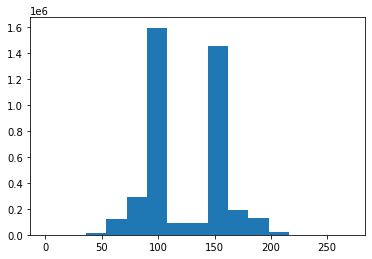

In [ ]:
nbp_hist_value= plt.hist(nbp_alarm_train['value'], bins =15)

In [ ]:
nbp_alarm_train_hi_expire = nbp_alarm_train[(nbp_alarm_train['NBP Alarm [High]'] == 1) & (nbp_alarm_train['hospital_expire_flag'] == 1)]
nbp_alarm_train_hi_noexpire = nbp_alarm_train[(nbp_alarm_train['NBP Alarm [High]'] == 1) & (nbp_alarm_train['hospital_expire_flag'] == 0)]
nbp_alarm_train_lo_expire = nbp_alarm_train[(nbp_alarm_train['NBP Alarm [Low]'] == 1) & (nbp_alarm_train['hospital_expire_flag'] == 1)]
nbp_alarm_train_lo_noexpire = nbp_alarm_train[(nbp_alarm_train['NBP Alarm [Low]'] == 1) & (nbp_alarm_train['hospital_expire_flag'] == 0)]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


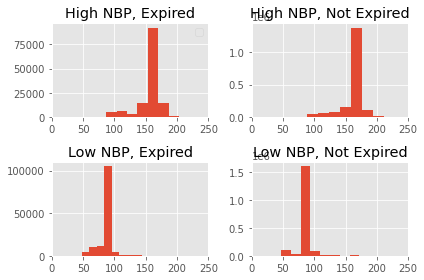

In [ ]:
plt.style.use('ggplot')
plt.close('all')

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(nbp_alarm_train_hi_expire['value'], 15, histtype='bar')
ax0.legend(prop={'size': 10})
ax0.set_title('High NBP, Expired')
ax0.set_xlim([0, 250])

ax1.hist(nbp_alarm_train_hi_noexpire['value'], 15, histtype='bar')
ax1.set_title('High NBP, Not Expired')
ax1.set_xlim([0, 250])

ax2.hist(nbp_alarm_train_lo_expire['value'], 15, histtype='bar')
ax2.set_title('Low NBP, Expired')
ax2.set_xlim([0, 250])

ax3.hist(nbp_alarm_train_lo_noexpire['value'], 15, histtype='bar')
ax3.set_title('Low NBP, Not Expired')
ax3.set_xlim([0, 250])

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


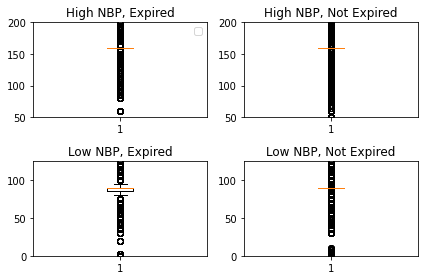

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.boxplot(nbp_alarm_train_hi_expire['valuenum'])
ax0.legend(prop={'size': 10})
ax0.set_title('High NBP, Expired')
ax0.set_ylim([50, 200])

ax1.boxplot(nbp_alarm_train_hi_noexpire['valuenum'])
ax1.set_title('High NBP, Not Expired')
ax1.set_ylim([50, 200])

ax2.boxplot(nbp_alarm_train_lo_expire['valuenum'])
ax2.set_title('Low NBP, Expired')
ax2.set_ylim([0, 125])

ax3.boxplot(nbp_alarm_train_lo_noexpire['valuenum'])
ax3.set_title('Low NBP, Not Expired')
ax3.set_ylim([0, 125])

fig.tight_layout()
plt.show()

# Resp

In [ ]:
resp_alarm.head()

,subject_id,itemid,charttime,label,category,value,valuenum,valueuom,Resp Alarm [High],Resp Alarm [Low]
0,27661,8553,2129-10-05 18:30:00,Resp Alarm [High],NaN,30.0,30.0,BPM,1,0
1,27661,8553,2129-07-14 01:00:00,Resp Alarm [High],NaN,30.0,30.0,BPM,1,0
2,27661,5819,2129-07-10 17:00:00,Resp Alarm [Low],NaN,8.0,8.0,BPM,0,1
3,27661,8553,2129-09-26 21:15:00,Resp Alarm [High],NaN,30.0,30.0,BPM,1,0
4,27661,5819,2129-09-28 06:00:00,Resp Alarm [Low],NaN,8.0,8.0,BPM,0,1


In [ ]:
resp_alarm.value.describe()

count    4.967244e+06
mean     2.160572e+01
std      1.510575e+01
min      0.000000e+00
25%      8.000000e+00
50%      3.000000e+01
75%      3.500000e+01
max      1.300000e+02
Name: value, dtype: float64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


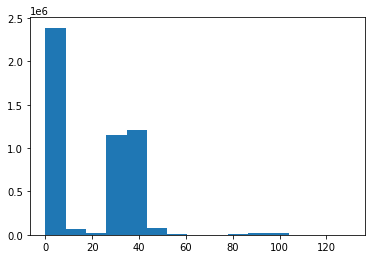

In [ ]:
resp_hist_value= plt.hist(resp_alarm_train['value'], bins =15)

In [ ]:
resp_alarm_train_hi_expire = resp_alarm_train[(resp_alarm_train['Resp Alarm [High]'] == 1) & (resp_alarm_train['hospital_expire_flag'] == 1)]
resp_alarm_train_hi_noexpire = resp_alarm_train[(resp_alarm_train['Resp Alarm [High]'] == 1) & (resp_alarm_train['hospital_expire_flag'] == 0)]
resp_alarm_train_lo_expire = resp_alarm_train[(resp_alarm_train['Resp Alarm [Low]'] == 1) & (resp_alarm_train['hospital_expire_flag'] == 1)]
resp_alarm_train_lo_noexpire = resp_alarm_train[(resp_alarm_train['Resp Alarm [Low]'] == 1) & (resp_alarm_train['hospital_expire_flag'] == 0)]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


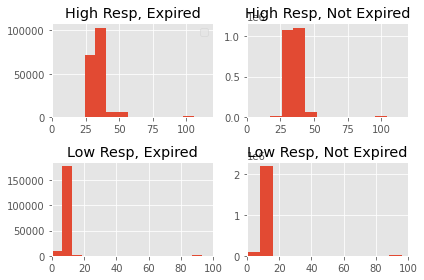

In [ ]:
plt.style.use('ggplot')
plt.close('all')

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(resp_alarm_train_hi_expire['value'], 15, histtype='bar')
ax0.legend(prop={'size': 10})
ax0.set_title('High Resp, Expired')
ax0.set_xlim([0, 120])

ax1.hist(resp_alarm_train_hi_noexpire['value'], 15, histtype='bar')
ax1.set_title('High Resp, Not Expired')
ax1.set_xlim([0, 120])

ax2.hist(resp_alarm_train_lo_expire['value'], 15, histtype='bar')
ax2.set_title('Low Resp, Expired')
ax2.set_xlim([0, 100])

ax3.hist(resp_alarm_train_lo_noexpire['value'], 15, histtype='bar')
ax3.set_title('Low Resp, Not Expired')
ax3.set_xlim([0, 100])

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


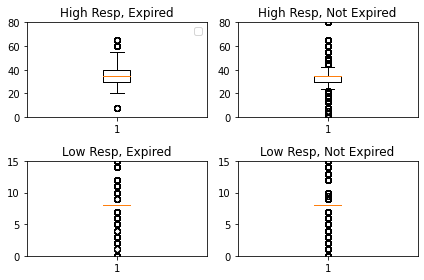

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.boxplot(resp_alarm_train_hi_expire['valuenum'])
ax0.legend(prop={'size': 10})
ax0.set_title('High Resp, Expired')
ax0.set_ylim([0, 80])

ax1.boxplot(resp_alarm_train_hi_noexpire['valuenum'])
ax1.set_title('High Resp, Not Expired')
ax1.set_ylim([0, 80])

ax2.boxplot(resp_alarm_train_lo_expire['valuenum'])
ax2.set_title('Low Resp, Expired')
ax2.set_ylim([0, 15])

ax3.boxplot(resp_alarm_train_lo_noexpire['valuenum'])
ax3.set_title('Low Resp, Not Expired')
ax3.set_ylim([0, 15])

fig.tight_layout()
plt.show()

# SpO2

In [ ]:
spO2_alarm.value.describe()

count    5.046087e+06
mean     9.456873e+01
std      9.276971e+00
min      0.000000e+00
25%      9.000000e+01
50%      9.300000e+01
75%      1.000000e+02
max      1.100000e+02
Name: value, dtype: float64

In [ ]:
spO2_alarm.value.nunique()

64

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


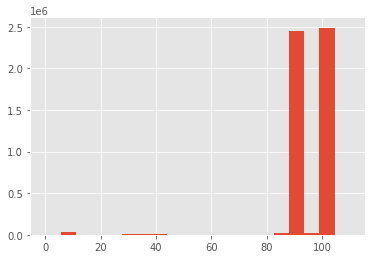

In [ ]:
spO2_hist_value= plt.hist(spO2_alarm_train['value'], bins =20)

In [ ]:
spO2_alarm_train_hi_expire = spO2_alarm_train[(spO2_alarm_train['SpO2 Alarm [High]'] == 1) & (spO2_alarm_train['hospital_expire_flag'] == 1)]
spO2_alarm_train_hi_noexpire = spO2_alarm_train[(spO2_alarm_train['SpO2 Alarm [High]'] == 1) & (spO2_alarm_train['hospital_expire_flag'] == 0)]
spO2_alarm_train_lo_expire = spO2_alarm_train[(spO2_alarm_train['SpO2 Alarm [Low]'] == 1) & (spO2_alarm_train['hospital_expire_flag'] == 1)]
spO2_alarm_train_lo_noexpire = spO2_alarm_train[(spO2_alarm_train['SpO2 Alarm [Low]'] == 1) & (spO2_alarm_train['hospital_expire_flag'] == 0)]

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
No handles with labels found to put in legend.


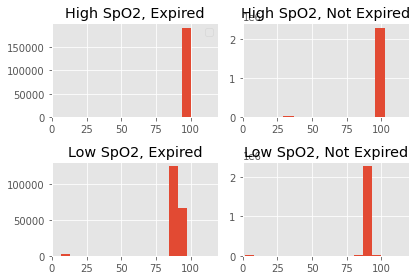

In [ ]:
plt.style.use('ggplot')
plt.close('all')

fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.hist(spO2_alarm_train_hi_expire['value'], 15, histtype='bar')
ax0.legend(prop={'size': 10})
ax0.set_title('High SpO2, Expired')
ax0.set_xlim([0, 120])

ax1.hist(spO2_alarm_train_hi_noexpire['value'], 15, histtype='bar')
ax1.set_title('High SpO2, Not Expired')
ax1.set_xlim([0, 120])

ax2.hist(spO2_alarm_train_lo_expire['value'], 15, histtype='bar')
ax2.set_title('Low SpO2, Expired')
ax2.set_xlim([0, 120])

ax3.hist(spO2_alarm_train_lo_noexpire['value'], 15, histtype='bar')
ax3.set_title('Low SpO2, Not Expired')
ax3.set_xlim([0, 120])

fig.tight_layout()
plt.show()

No handles with labels found to put in legend.


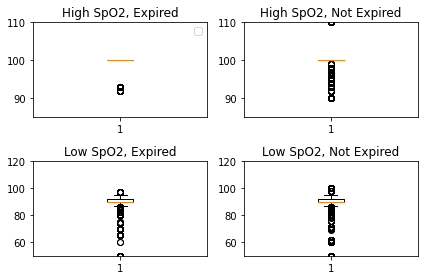

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
ax0, ax1, ax2, ax3 = axes.flatten()

ax0.boxplot(spO2_alarm_train_hi_expire['valuenum'])
ax0.legend(prop={'size': 10})
ax0.set_title('High SpO2, Expired')
ax0.set_ylim([85, 110])

ax1.boxplot(spO2_alarm_train_hi_noexpire['valuenum'])
ax1.set_title('High SpO2, Not Expired')
ax1.set_ylim([85, 110])

ax2.boxplot(spO2_alarm_train_lo_expire['valuenum'])
ax2.set_title('Low SpO2, Expired')
ax2.set_ylim([50, 120])

ax3.boxplot(spO2_alarm_train_lo_noexpire['valuenum'])
ax3.set_title('Low SpO2, Not Expired')
ax3.set_ylim([50, 120])

fig.tight_layout()
plt.show()